### Reconstruction using a naive DCT compressive sensing approach

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda as cuda
import torch.nn.functional as F
from torch.autograd import Variable

if cuda.is_available():
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor


In [10]:
# %load simulate_cassi.py
# Simulate CASSI (Spatial-spectral or SS-CASSI, to be specific)
import numpy as np
import torch
from torch.autograd import Variable
from scipy.ndimage.interpolation import shift
import matplotlib.pyplot as plt

def generate_mask(inchannels, height, width):
    # Generate random binary mask
    mask = np.random.choice(2, size=(height, width+inchannels), p=(0.5, 0.5))
#     plt.imshow(mask)

    # Shear mask by different amounts for each channel
    middlechannel = int((inchannels - 1)/2)
    shifts = [ shift for shift in range(-middlechannel, middlechannel+1) ]

    # Apply mask to each channel (element-wise multiplication)
    maskblock = np.zeros((inchannels, height, width+inchannels), dtype=np.float32)
    for i, shift_val in enumerate(shifts):
    #     print(shift_val)
        # Shift mask along horizontal axis only
        # in (C, H, W) order (for pytorch later)
        maskblock[i,:,:] = shift(mask, (0, shift_val), mode='constant')
    middle = (width+inchannels+1)/2
    # print(middle)
    # print(range(int(middle-width/2),int(middle+width/2)))
    maskblock = maskblock[:, :, int(middle-width/2):int(middle+width/2)]
    # print(maskblocksquare.shape)
    # plt.imshow(maskblocksquare[25,:,:])
    maskblock = torch.Tensor(maskblock)
    maskblock = Variable(maskblock, requires_grad=False)
    maskblock = maskblock.unsqueeze(0) # Make 4d tensor
    # print(maskblock.shape)
    return maskblock
    
# Define image formation model
def image_formation(input_, maskblock):
    """Given an (1, inchannels, height, width) data block input_ and
    a torch tensor mask, compute the image that the camera sensor should see."""
    # Multiply elementwise by mask
#     print(type(maskblock))
#     print(type(input_))
#     print(maskblock.shape)
#     print(input_.shape)
    x = maskblock*input_
#     print(x.shape)
    # Sum along wavelength dimension to get a 2D image (1, height, width)
    return torch.sum(x, dim=1).unsqueeze(0) #Unsqueeze to make (1, 1, height, width)

In [11]:
# %load hyperspectral_dataset.py
# Load data
import torch
from torch.utils.data import Dataset
import csv, numpy as np
import os
import OpenEXR as exr, Imath
from collections import defaultdict
from PIL import Image
from skimage.transform import resize
####################
# Helper functions #
####################

def readEXRImage(filepath, channelrange):
    """Helper function for reading .exr files from the KAIST dataset.
    Returns an array with dimension ordering (C, H, W) as required by pytorch.
    """
    file = exr.InputFile(filepath)
    channels = ["w{}nm".format(wavelength) for wavelength in channelrange]
    header = file.header()
    ncols = header["displayWindow"].max.x+1
    nrows = header["displayWindow"].max.y+1
    pt = Imath.PixelType(Imath.PixelType.HALF)
    imgstrs = file.channels(channels, pt)
    full = np.zeros((len(channels), nrows, ncols), dtype=np.float16)
    for i, imgstr in enumerate(imgstrs):
        red = np.frombuffer(imgstr, dtype=np.float16)
        full[i,:,:] = np.reshape(red, (nrows, ncols))
    return full

def readPNGImage(filedir, filename, channelrange, minwavelength, increment):
    """Helper function for reading patches from the set of png files from the CAVE dataset.
    """
    indexes = [int((wavelength-minwavelength)/increment + 1) for wavelength in channelrange]
    # Get image size:
    img = Image.open(os.path.join(filedir, "{}_{:02}.png".format(filename, 1)))
    full = np.zeros((len(channelrange),) + img.size, dtype=np.float16)
    img.close()
    for i, index in enumerate(indexes):
        img = Image.open(os.path.join(filedir, "{}_{:02}.png".format(filename, index)))
        # Divide by max val of np.uint16 to normalize image
        full[i,:,:] = np.array(img, dtype=np.float32)/np.iinfo(np.uint16).max
    return full

###########
# Dataset #
###########
# For reference, the csv field names: 
# fieldnames = ["type", "dir", "name", "row", "col", "side", "scale", "flip"]

class HyperspectralDataset(Dataset):
    def __init__(self, csvfile, minwavelength, maxwavelength, nchannels, height, width):
        """Open and load the lines of the csvfile."""
        self.minwavelength = minwavelength
        self.maxwavelength = maxwavelength
        self.channelrange = range(self.minwavelength, self.maxwavelength+1, 10)
        
        
        # Store dictionaries mapping the image name to
        # - a list of entries that stem from that image
        # - the datatype (exr or png) of the image
        # - the filepath to that image
        self.update_entries(csvfile)

    def update_entries(self, csvfile):
        """Refresh the dataset without reloading the images, but adding a different set of csv files."""
        self.dataEntries = []
        self.namesToImages = {}
        with open(csvfile, "r") as f:
            reader = csv.DictReader(f)
            for entry in reader:
                self.dataEntries.append(entry)
                # Add the full image to the dict if not already included.
                if entry["name"] not in self.namesToImages:
                    print("loading {}".format(entry["name"]))
                    # Need to read the image into the dictionary
                    if entry["type"] == "exr":
                        filepath = os.path.join(entry["dir"], entry["name"])
                        self.namesToImages[entry["name"]] = readEXRImage(filepath, self.channelrange)
                    elif entry["type"] == "png":
                        self.namesToImages[entry["name"]] = readPNGImage(entry["dir"], entry["name"],
                                                                           self.channelrange,
                                                                           self.minwavelength,
                                                                           self.maxwavelength)
                    else:
                        raise ValueError("Invalid entry at row {} - Cannot load data of type '{}'.".format(idx, dtype))
                    print("\tSize: {} bytes.".format(self.namesToImages[entry["name"]].nbytes))
                    
    def __len__(self):
        return len(self.dataEntries)
    
    def __getitem__(self, idx):
        entry = self.dataEntries[idx]
        image = self.namesToImages[entry["name"]]
        side = int(entry["side"])
        scale = float(entry["scale"])
        i = int(entry["row"])
        j = int(entry["col"])
        shape = (int(side/scale),
                 int(side/scale)
                )
        patch = image[:, i:i+shape[0], j:j+shape[0]]
        # Resizing
        patch = resize(patch, (patch.shape[0], side, side), mode="constant")
        # Flip if necessary:
        if entry["flip"]:
            patch = np.flip(patch, axis=2) # Horizontal flip

        # Convert to Torch tensor and return
        out = torch.Tensor(patch.copy()).type(dtype).cpu()
        return out



In [84]:
# %load visualize_hyperspectral.py
from matplotlib.colors import LinearSegmentedColormap
# Visualize hyperspectral images
def plot_all_channels(data, channels_to_wavelengths):
    """Plot the channels in the data, color coded by wavelength.
    channels_to_wavelengths[i] gives the wavelength in nm of the ith channel."""
    plt.figure(figsize=(24, 13))
    inchannels = data.shape[1]
    for channel in range(inchannels):
        wavelength = channels_to_wavelengths[channel]
        r, g, b = spectral_color(wavelength)
        
#         low = hsv_to_rgb(h, s, 0)
#         high = hsv_to_rgb(h, s, 1)
        cdict = {"red": ((0.0, 0.0, 0.0),
                         (1.0, r, r)),
                 "green": ((0.0, 0.0, 0.0),
                           (1.0, g, g)),
                 "blue":  ((0.0, 0.0, 0.0),
                           (1.0, b, b))
        }
        lambd = LinearSegmentedColormap('lambd', cdict)

        ax = plt.subplot(4, inchannels//4+1, channel+1)

        ax.imshow(data[0,channel,:,:], cmap=lambd, origin="lower")
        plt.axis('off')
        plt.tight_layout

# Adapted from
# https://stackoverflow.com/questions/3407942/rgb-values-of-visible-spectrum/22681410#22681410
def spectral_color(l): # RGB <0,1> <- lambda l <400,700> [nm]
    # R
    if l>=400.0 and l<410.0:
        t = (l-400.0)/(410.0-400.0)
        r = (0.33*t)-(0.20*t*t)
    elif l>=410.0 and l<475.0:
        t = (l-410.0)/(475.0-410.0)
        r = 0.14 - (0.13*t*t)
    elif l>=545.0 and l<595.0:
        t = (l-545.0)/(595.0-545.0)
        r = (1.98*t)-(     t*t)
    elif l>=595.0 and l<650.0:
        t = (l-595.0)/(650.0-595.0)
        r = 0.98+(0.06*t)-(0.40*t*t)
    elif l>=650.0 and l<700.0:
        t = (l-650.0)/(700.0-650.0)
        r = 0.65-(0.84*t)+(0.20*t*t)
    else:
        r = 0.0
    # G
    if l>=415.0 and l<475.0:
        t = (l-415.0)/(475.0-415.0)
        g = (0.80*t*t)
    elif l>=475.0 and l<590.0:
        t = (l-475.0)/(590.0-475.0)
        g = 0.8 +(0.76*t)-(0.80*t*t)
    elif l>=585.0 and l<639.0:
        t = (l-585.0)/(639.0-585.0)
        g = 0.84-(0.84*t)
    else:
        g = 0.0
    # B
    if l>=400.0 and l<475.0:
        t = (l-400.0)/(475.0-400.0)
        b = (2.20*t)-(1.50*t*t)
    elif l>=475.0 and l<560.0:
        t = (l -475.0)/(560.0-475.0)
        b = 0.7 - t+(0.30*t*t)
    else:
        b = 0.0
    return r, g, b

In [13]:
# Load val image(s)
inchannels = 29
height = 96
width = 96
val_data_csv = "data/kaist_set/kaist_select.csv"
val_data = HyperspectralDataset(val_data_csv, 420, 700, inchannels, height, width)

loading scene22_reflectance.exr
	Size: 529464832 bytes.
loading scene17_reflectance.exr
	Size: 529464832 bytes.
loading scene26_reflectance.exr
	Size: 529464832 bytes.


OrderedDict([('type', 'exr'), ('dir', 'data/KAIST'), ('name', 'scene17_reflectance.exr'), ('row', '1248'), ('col', '1510'), ('side', '96'), ('scale', '1'), ('flip', 'False')])


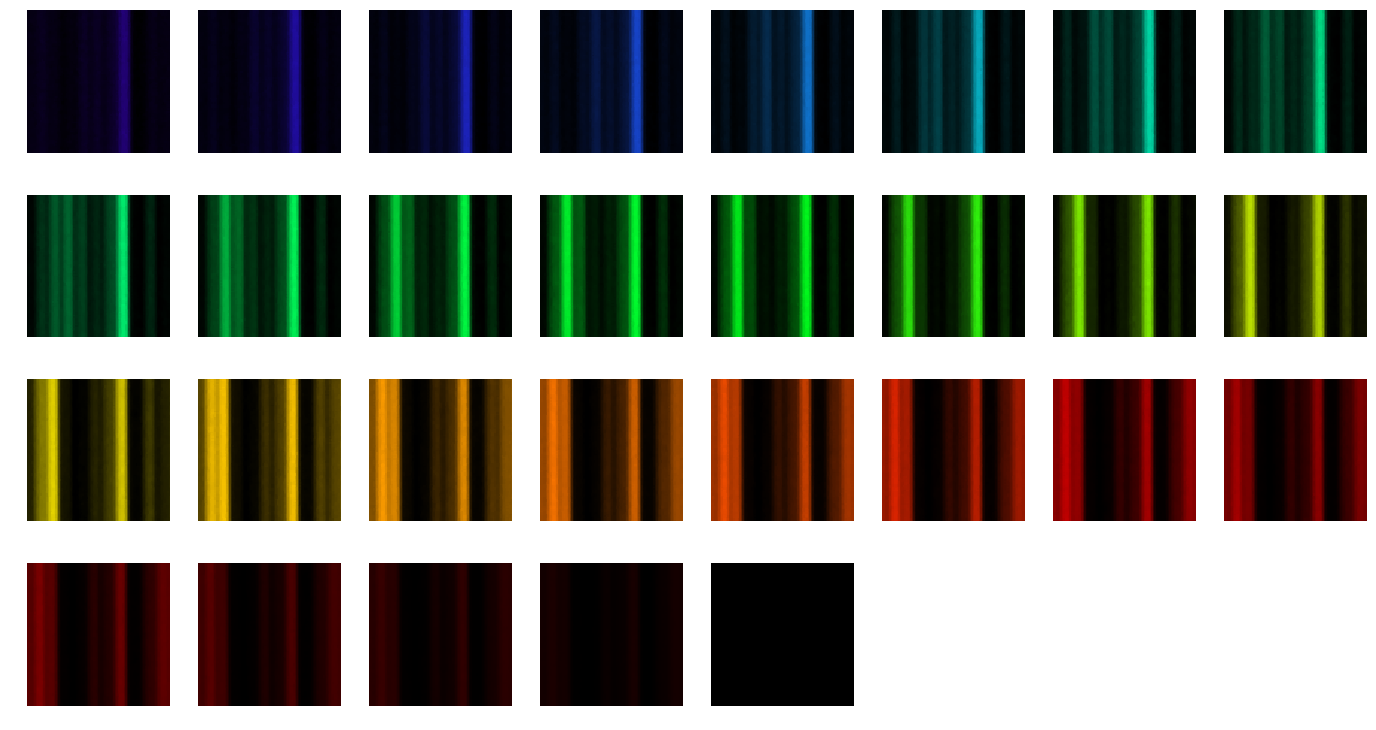

In [94]:
# Generate mask:
maskblock = generate_mask(inchannels, height, width).type(dtype)

# Load image to reconstruct
n=7
print(val_data.dataEntries[n])
true_img = Variable(torch.Tensor(val_data[n]).type(dtype), requires_grad=False)
true_img = true_img.unsqueeze(0) # make 4d Variable
target = image_formation(true_img, maskblock)
# print(target.shape)
# plt.imshow(target.data[0,0,:,:]")
# type(target)
# print(target.is_cuda)
# print(type(target))
plot_all_channels(true_img.data, range(420, 721, 10))

### ADMM Reconstruction
#### Optimization problem
$$ \min_\alpha \quad \|i - \Phi (x)\|_2^2 + \tau\|\nabla_\lambda x\|_2^2 + \lambda\|\text{DCT}(x)\|_1 $$

where $$ \tau\|\nabla_\lambda x\|_2^2$$ encourages smooth gradients in the spectral dimension

Reformulate as
$$ \min_\alpha \quad \|i - \Phi(x)\|_2^2 + \tau\|\nabla_\lambda x\|_2^2 + \lambda\|z\|_1 $$
$$ \text{s.t.} \quad \text{DCT}(x) - z = 0$$

Solve using ADMM with updates:
$$x^{(t+1)} = \arg \min_x \|i - \Phi (x)\|_2^2 + \tau\|\nabla_\lambda x\|_2^2 + \frac{\rho}{2}\|\text{DCT}(x) - z^{t} + u^{(t)}\|_2^2$$
$$z^{(t+1)} = \arg \min_z \lambda\|z\|_1 + \frac{\rho}{2}\|\text{DCT}(x^{(t+1)}) - z + u^{(t)}\|_2^2$$
$$u^{(t+1)} = u^{(t)} + \text{DCT}(x^{(t+1)}) - z^{(t+1)} $$

Solve the x update with gradient descent (Adam).
Solve the z update with element-wise soft thresholding.

In [95]:
# Create Pytorch version of DCT2 module
from scipy.fftpack import dct, idct
from torch.autograd import Function


# Implement dct2 and idct2 manually because dumb
def dct2(x, axes=(0,1)):
    return dct(dct(x, axis=axes[0], norm='ortho'), axis=axes[1], norm='ortho')

def idct2(x, axes=(0,1)):
    return idct(idct(x, axis=axes[0], norm = 'ortho'), axis=axes[1], norm='ortho')

# Test
# a = np.random.randn(5, 5)
# a = np.zeros((5, 5))
# a[0,0] = 1
# b = dct2(a)
# c = idct2(b)
# print(a)
# print(b)
# print(c)

class ScipyDCT2(Function):
    def __init__(self, dtype):
        super(ScipyDCT2, self).__init__()
        self.dtype=dtype
    
    def forward(self, input_):
        numpy_input = input_.cpu().numpy()
        result = dct2(numpy_input, (-2,-1)) #do the dct on the last two axes
        return torch.FloatTensor(result).type(self.dtype)

    def backward(self, grad_output):
        numpy_go = grad_output.cpu().numpy()
        result = idct2(numpy_go, (-2,-1)) 
        return torch.FloatTensor(result).type(self.dtype)

class ScipyiDCT2(Function):
    def __init__(self, dtype):
        super(ScipyiDCT2, self).__init__()
        self.dtype=dtype
    
    def forward(self, input_):
        numpy_input = input_.cpu().numpy()
        result = idct2(numpy_input, (-2,-1)) #do the dct on the last two axes
        return torch.FloatTensor(result).type(self.dtype)

    def backward(self, grad_output):
        numpy_go = grad_output.cpu().numpy()
        result = dct2(numpy_go, (-2,-1)) 
        return torch.FloatTensor(result).type(self.dtype)
    
def scipy_dct2(input_):
    return ScipyDCT2(dtype)(input_)

def scipy_idct2(input_):
    return ScipyiDCT2(dtype)(input_)



In [96]:
# MSE Loss
# Need to be able to compute gradients w.r.t. input and target
def mse_loss(input_, target):
    return torch.sum((input_ - target)**2) #/ input_.data.nelement()

def proximal_x(target, x, z, u, image_formation, maskblock, rho, smooth, num_adam_iters, lr):
    """Adam"""
    optimizer = optim.Adam([x], lr = lr)
    for it in range(num_adam_iters):
        optimizer.zero_grad()
        data_fidelity = mse_loss(image_formation(x, maskblock), target)
        augmented_lagrangian = mse_loss(scipy_dct2(x) + u, z)
        spectral_grad = torch.cat((x[:,1:,:,:], 
                                   Variable(torch.zeros(x.shape[0], 1, x.shape[2], x.shape[3]).type(dtype), requires_grad=False)),
                                   dim=1) \
                        - x
        smooth_spectrum = torch.sum(spectral_grad**2)
        overall_loss = data_fidelity + smooth*smooth_spectrum + (rho/2)*augmented_lagrangian
        overall_loss.backward(retain_graph=True)
        optimizer.step()
        if not (it % 50):
            print("\titeration: {}\tloss: {}".format(it, overall_loss.data[0]))
    return x

def proximal_z(v, lambd, rho):
    """Element-wise soft thresholding operator.
    Used for Anisotropic TV prior."""
    out = F.relu(v - lambd/rho) - F.relu(-v - lambd/rho)
    return out


    



In [97]:
# Initialize ADMM
num_ADMM_steps = 10
rho = 1e-2
smooth = 1
lambd = 1e-3

num_adam_iters= 200
lr = 1e-2

x = Variable(torch.randn(1, inchannels, height, width).type(dtype), requires_grad=True)
z = Variable(torch.randn(1, inchannels, height, width).type(dtype), requires_grad=False)
u = Variable(torch.randn(1, inchannels, height, width).type(dtype), requires_grad=False)

# Run ADMM
for admm_i in range(num_ADMM_steps):
    print("iteration: {}".format(admm_i))
    # Update alpha
    newx = proximal_x(target, x, z, u, 
                      image_formation, maskblock,
                      rho, smooth, num_adam_iters, lr)
    # Update z
    newz = proximal_z(scipy_dct2(newx) + u, lambd, rho)
    # Update u
    newu = u + scipy_dct2(newx) - newz
    # Calculate loss
    loss = mse_loss(target, image_formation(newx, maskblock)) + \
               lambd * torch.sum(torch.abs(scipy_dct2(newx)))
#            tau1 * mse_loss(alpha, Encoder(Decoder(newalpha))) + \ 
    print("loss: {}".format(loss.data[0]))
    # Stop if parameters aren't changing:
#     if (torch.sum(torch.abs(alpha - newalpha)) +
#        torch.sum(torch.abs(z - newz)) +
#        torch.sum(torch.abs(u - newu))).data[0] < eps:
#         break
#     else:
    x = newx
    z = newz
    u = newu




iteration: 0
	iteration: 0	loss: 726078.4375
	iteration: 50	loss: 251931.109375
	iteration: 100	loss: 107686.0859375
	iteration: 150	loss: 52716.4375
loss: 390.21734619140625
iteration: 1
	iteration: 0	loss: 27244.24609375
	iteration: 50	loss: 6022.029296875
	iteration: 100	loss: 2744.7568359375
	iteration: 150	loss: 1891.7281494140625
loss: 38.85878372192383
iteration: 2
	iteration: 0	loss: 442.6101989746094
	iteration: 50	loss: 106.23051452636719
	iteration: 100	loss: 52.240081787109375
	iteration: 150	loss: 45.10673904418945
loss: 5.557220935821533
iteration: 3
	iteration: 0	loss: 38.352813720703125
	iteration: 50	loss: 37.83021545410156
	iteration: 100	loss: 37.46421813964844
	iteration: 150	loss: 37.44023895263672
loss: 5.9851508140563965
iteration: 4
	iteration: 0	loss: 37.0491828918457
	iteration: 50	loss: 37.4100341796875
	iteration: 100	loss: 37.22975158691406
	iteration: 150	loss: 37.25341796875
loss: 6.63070821762085
iteration: 5
	iteration: 0	loss: 36.406307220458984
	itera

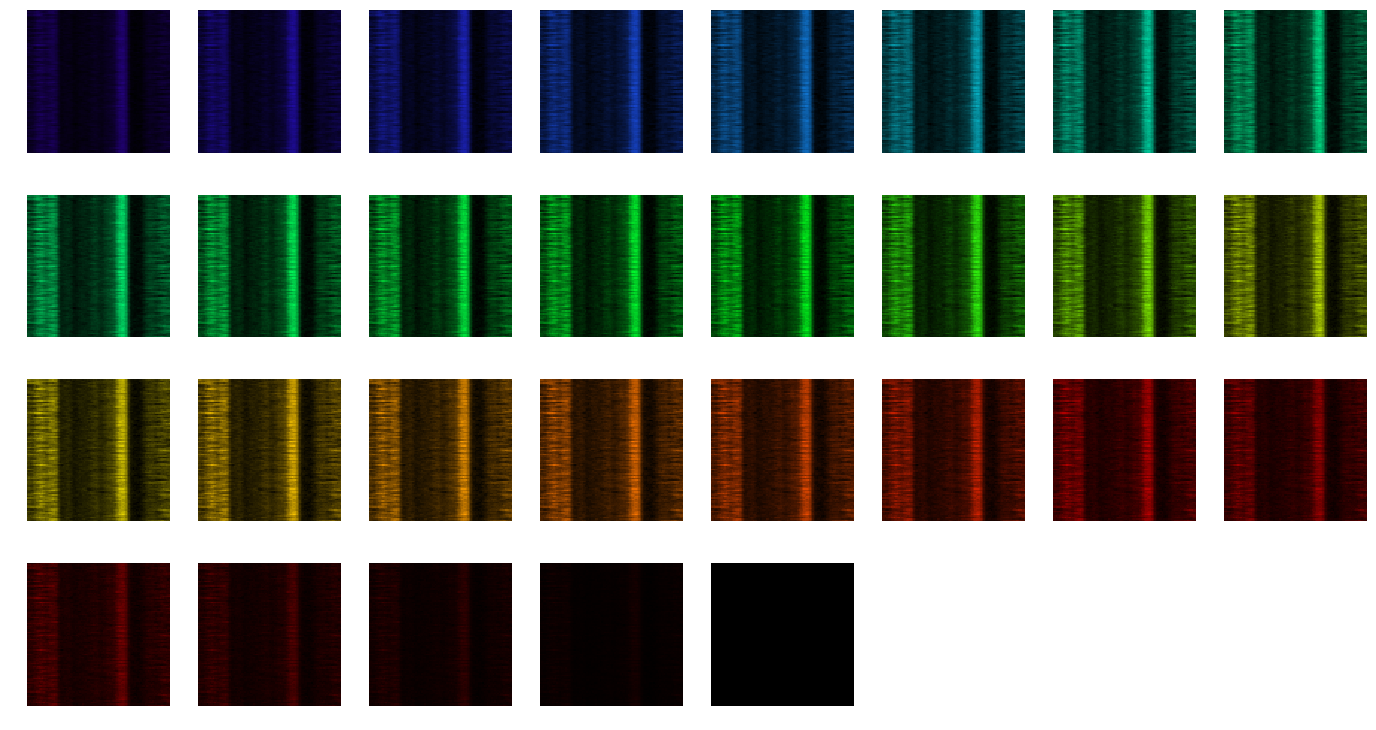

In [98]:
# Plot Decoded image
recon = x.data
plot_all_channels(recon, range(420, 701, 10))

In [99]:
# Compute PSNR
from skimage.measure import compare_psnr
compare_psnr(true_img.data.cpu().numpy(), recon.cpu().numpy())

17.093884747795776

Text(0.5,0,'wavelength (nm)')

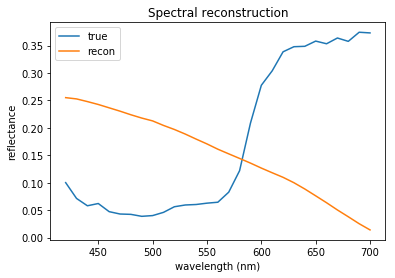

In [100]:
plt.plot(range(420, 701, 10), true_img.data[0,:,4,4].cpu().numpy(), label="true")
plt.plot(range(420,701, 10), recon[0,:,4,4].cpu().numpy(), label="recon")
plt.legend()
plt.title("Spectral reconstruction")
plt.ylabel("reflectance")
plt.xlabel("wavelength (nm)")

In [ ]:
x = Variable(torch.randn(1, 1, 5, 5).type(dtype), requires_grad=True)
y = scipy_dct2(x)
z = torch.norm(y)**2
z.backward()
print(x.grad)
print(x)